In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

In [2]:
h, w = 160, 160

x_train=[]
y_train=[]
x_test=[]
y_test=[]

path_train_low='../../dataSets/ref/our485/low/'
path_train_high='../../dataSets/ref/our485/high/'
path_test_low='../../dataSets/ref/eval15/low/'
path_test_high='../../dataSets/ref/eval15/high/'

print('\nLoding Train dataset :')
i=0;
for img in os.listdir(path_train_low):
    img_low_path=os.path.join(path_train_low, img)
    img_high_path=os.path.join(path_train_high, img)
    
    img_low=load_img(img_low_path, target_size=(h,w))
    img_low=img_to_array(img_low)/255.
    
    i=i+1
    print("{:.2f}".format(i/4.89)+' %',end='\r')
    
    img_high=load_img(img_high_path, target_size=(h,w))
    img_high=img_to_array(img_high)/255.
    
    x_train.append(img_low)
    y_train.append(img_high)
    
print('\nLoding Test dataset :')
i=0;
for img in os.listdir(path_test_low):
    img_low_path=os.path.join(path_test_low, img)
    img_high_path=os.path.join(path_test_high, img)
    
    img_low=load_img(img_low_path, target_size=(h,w))
    img_low=img_to_array(img_low)/255.
    
    i=i+1
    print("{:.2f}".format(i/0.14)+' %',end='\r')
    
    img_high=load_img(img_high_path, target_size=(h,w))
    img_high=img_to_array(img_high)/255.
    
    x_test.append(img_low)
    y_test.append(img_high)

x_train=np.array(x_train, dtype="float32")
y_train=np.array(y_train, dtype="float32")

x_test=np.array(x_test, dtype="float32")
y_test=np.array(y_test, dtype="float32")


Loding Train dataset :
100.00 %
Loding Test dataset :


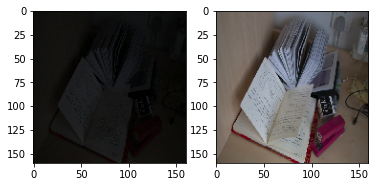

In [3]:
fig=plt.figure()

f=fig.add_subplot(1,2,1)
s=fig.add_subplot(1,2,2)

f.imshow(x_test[6])
s.imshow(y_test[6])

In [4]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input,add,Conv2D,MaxPooling2D,UpSampling2D,Flatten,Dropout,Dense,BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Concatenate,Lambda

def f(x):
    I = tf.math.add(0.29*x[:,:,:,0], tf.math.add(0.58*x[:,:,:,1], 0.11*x[:,:,:,2]))
    I = 1 - I
    I = tf.expand_dims(I , -1)
    return I

def InstantiateModel(in_):
    channel = 32
    kernal_size = (4, 4)
    
    #AM
    def AM(in_AM):
        return Lambda(lambda x: f(x))(in_AM)
    
    #NM
    def NM(in_NM):
        nm_conv0 = Conv2D(channel, kernal_size, strides=1, padding='same', activation=None)(in_NM)
        
        nm_conv1 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(nm_conv0)
        nm_conv2 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(nm_conv1)
        nm_conv3 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(nm_conv2)
        nm_conv4 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(nm_conv3)
        
        nm_model = Conv2D(1, (1,1), padding='same', activation=None)(nm_conv4)
        return nm_model
    
    #EM
    def EM(in_EM):
        em_conv0 = Conv2D(channel, kernal_size, strides=1, padding='same', activation=None)(in_EM)
        
        em_conv1 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(em_conv0)
        em_conv2 = Conv2D(channel/2, kernal_size, strides=1, padding='same', activation='relu')(em_conv1)
        em_conv3 = Conv2D(channel/4, kernal_size, strides=1, padding='same', activation='relu')(em_conv2)

        em_deconv3 = Conv2DTranspose(channel/4, kernal_size, strides=1, padding='same', activation='relu')(em_conv3)
        em_deconv2 = Conv2DTranspose(channel/2, kernal_size, strides=1, padding='same', activation='relu')(em_deconv3)
        em_deconv1 = Conv2DTranspose(channel, kernal_size, strides=1, padding='same', activation='relu')(em_deconv2)
        
        em_model = Conv2D(3, (1,1), padding='same', activation=None)(em_deconv1)
        return em_model
    
    def EM1(in_EM):
        em_conv0 = Conv2D(channel, kernal_size, strides=1, padding='same', activation=None)(in_EM)
        
        em_conv1 = Conv2D(channel, kernal_size, strides=2, padding='same', activation='relu')(em_conv0)
        em_conv2 = Conv2D(channel, kernal_size, strides=2, padding='same', activation='relu')(em_conv1)
        em_conv3 = Conv2D(channel, kernal_size, strides=2, padding='same', activation='relu')(em_conv2)

        em_up3 = UpSampling2D((2,2))(em_conv3)
        em_deconv3 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(em_up3)+em_conv2
        em_up2 = UpSampling2D((2,2))(em_deconv3)
        em_deconv2 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(em_up2)+em_conv1
        em_up1 = UpSampling2D((2,2))(em_deconv2)
        em_deconv1 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(em_up1)+em_conv0
        
        em_model = Conv2D(3, (1,1), padding='same', activation=None)(em_deconv1)
        return em_model
    
    am=AM(in_)
    nm=NM(Concatenate()([in_,am]))
    
    #FEM
    conv0 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(in_)
    conv1 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(conv0)
    conv2 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(conv1)
    conv3 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(conv2)
    conv4 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(conv3)
    
    #FM
    conv0 = EM(Concatenate()([conv0,am,nm]))
    conv1 = EM(Concatenate()([conv1,am,nm]))
    conv2 = EM1(Concatenate()([conv2,am,nm]))
    conv3 = EM1(Concatenate()([conv3,am,nm]))
    conv4 = EM1(Concatenate()([conv4,am,nm]))
    
    out = Concatenate()([conv0, conv1, conv2, conv3, conv4])
    out = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(out)
    out = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(out)
    out = Conv2D(3, (1,1), activation='sigmoid', padding='same', strides=1)(out)
    
    return out

In [5]:
Input_Sample = Input(shape=(h, w, 3))
Output_ = InstantiateModel(Input_Sample)
model = Model(inputs=Input_Sample, outputs=Output_)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 160, 160, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 160, 160, 4)  0           input_1[0][0]                    
                                                                 lambda[0][0]                     
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 32) 2080        concatenate[0][0]     

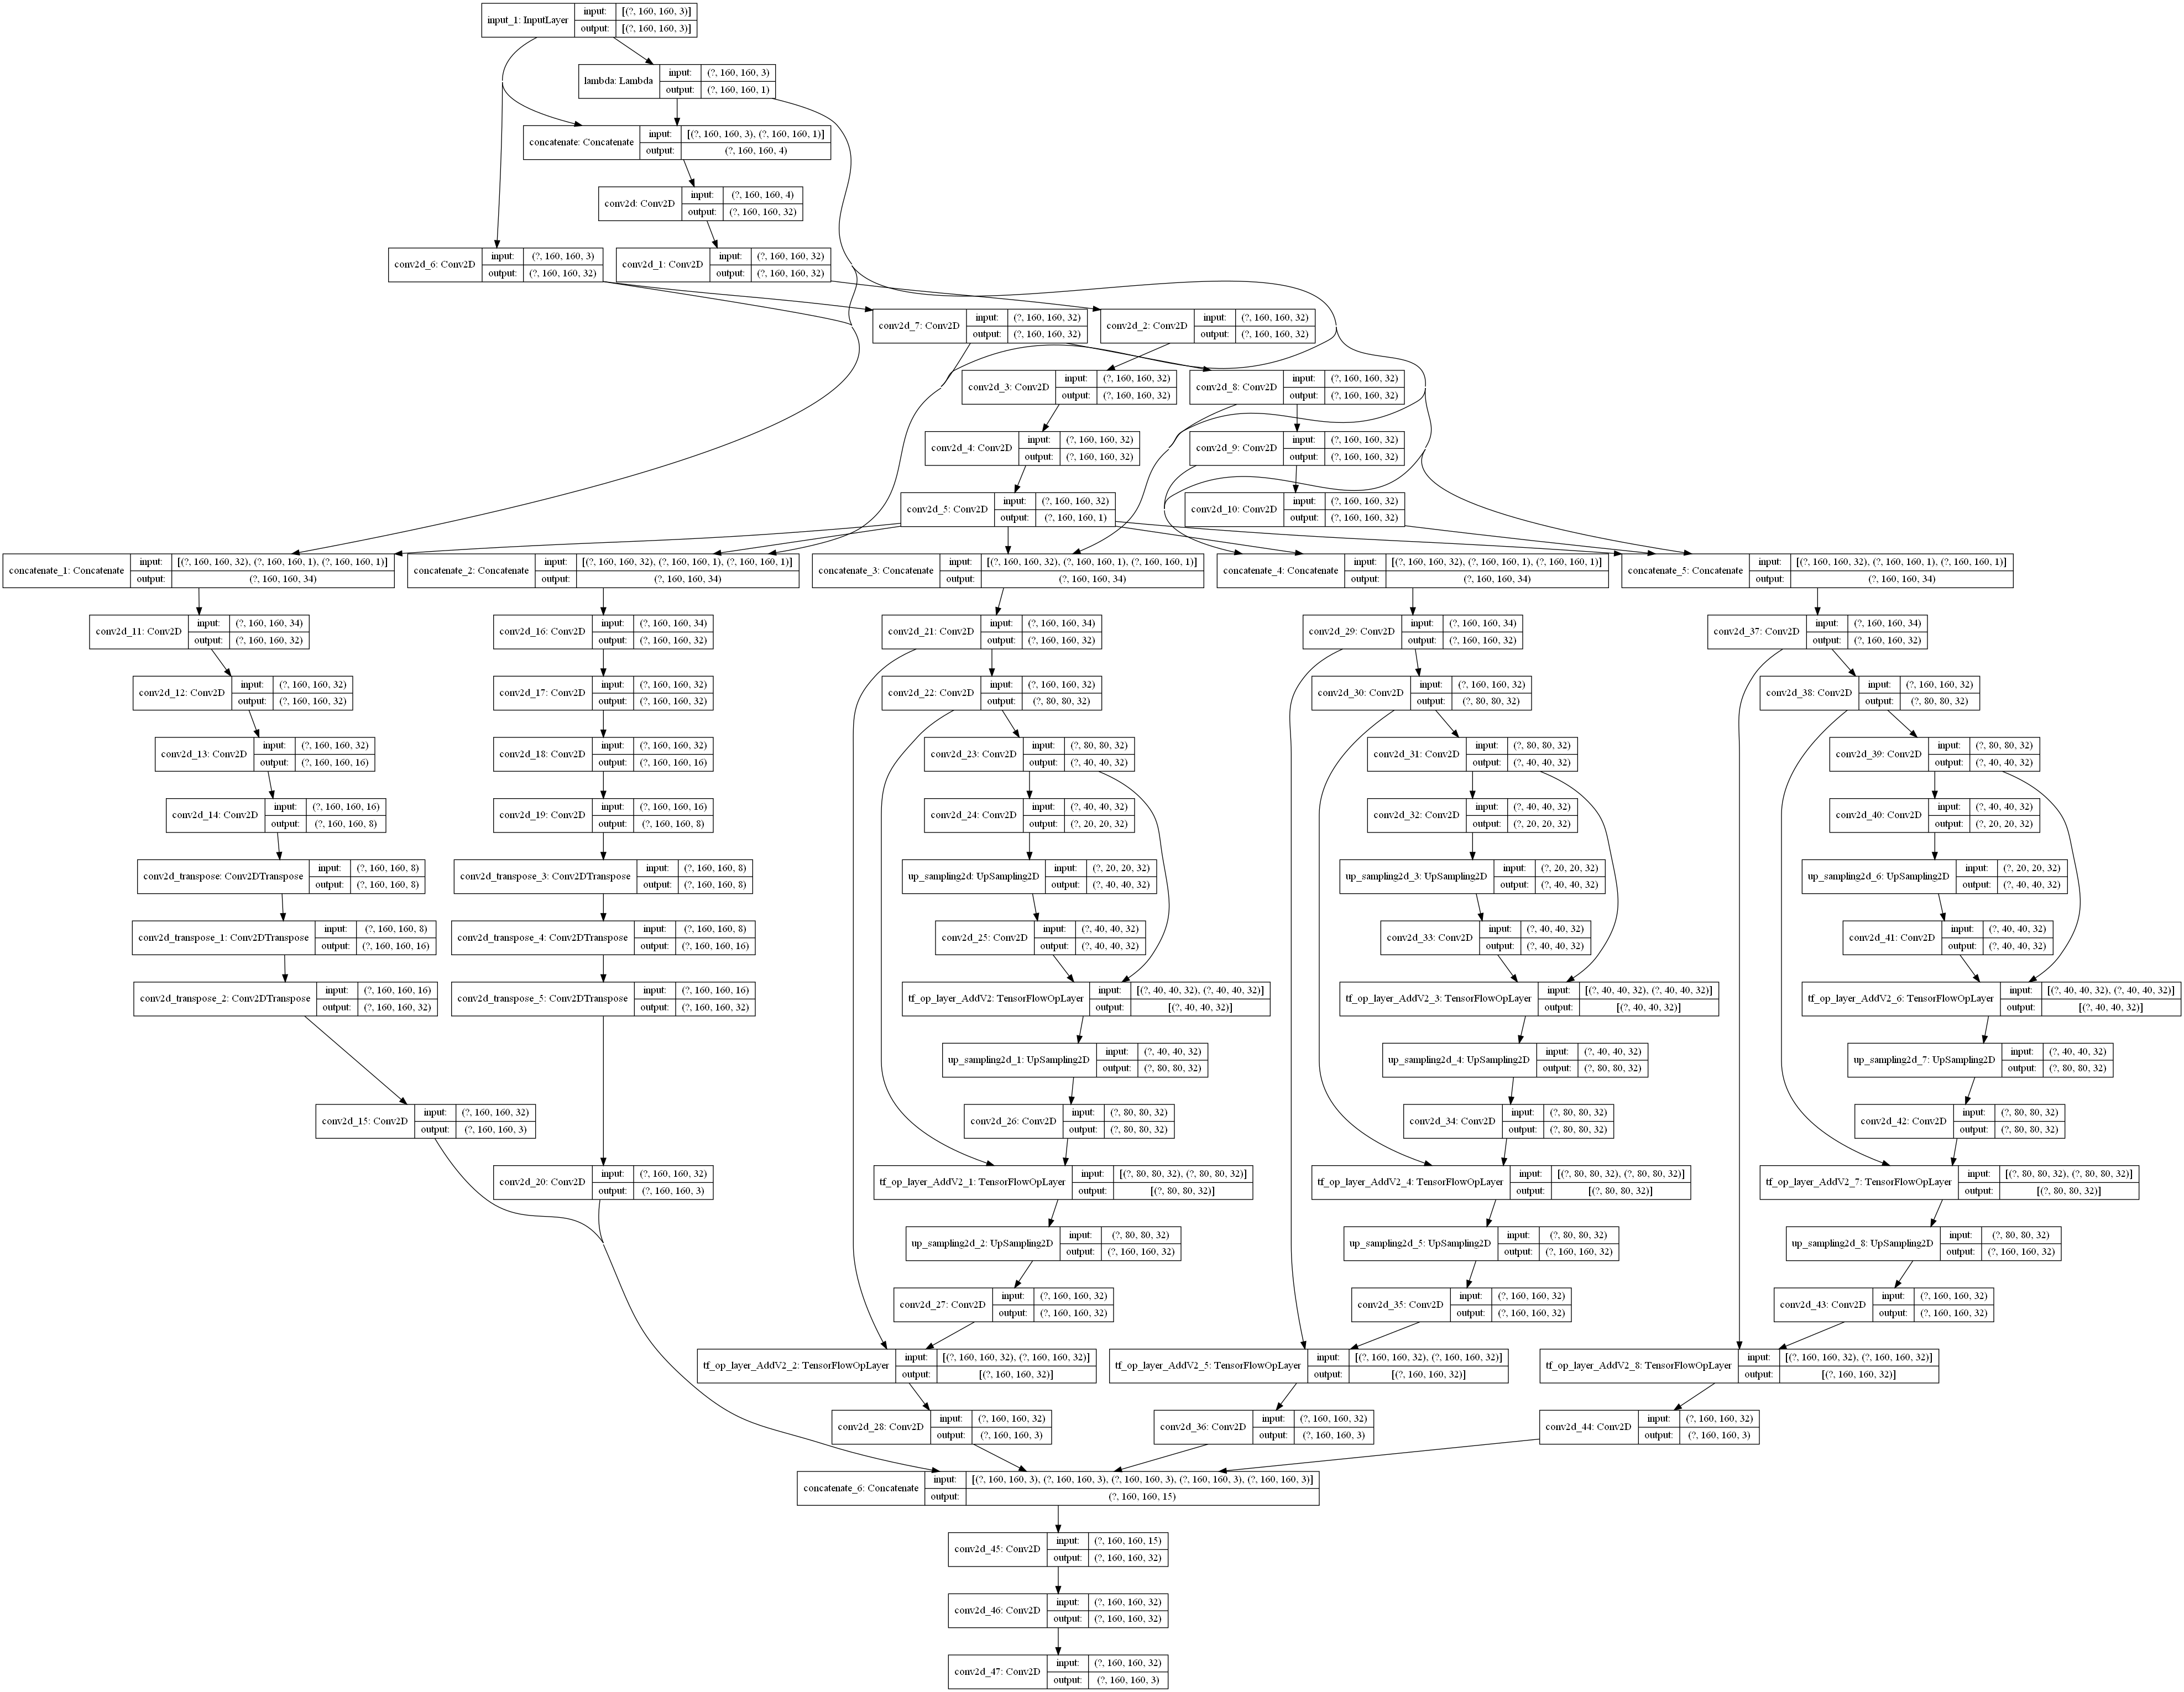

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model.png',show_shapes=True, show_layer_names=True)

In [7]:
def _tf_fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x_data, y_data = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]

    x_data = np.expand_dims(x_data, axis=-1)
    x_data = np.expand_dims(x_data, axis=-1)

    y_data = np.expand_dims(y_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)

    x = tf.constant(x_data, dtype=tf.float32)
    y = tf.constant(y_data, dtype=tf.float32)

    g = tf.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g / tf.reduce_sum(g)

def tf_ssim(img1, img2, cs_map=False, mean_metric=True, size=11, sigma=1.5):
    window = _tf_fspecial_gauss(size, sigma) # window shape [size, size]
    K1 = 0.01
    K2 = 0.03
    L = 1  # depth of image (255 in case the image has a differnt scale)
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    mu1 = tf.nn.conv2d(img1, window, strides=[1,1,1,1], padding='VALID')
    mu2 = tf.nn.conv2d(img2, window, strides=[1,1,1,1],padding='VALID')
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    sigma1_sq = tf.nn.conv2d(img1*img1, window, strides=[1,1,1,1],padding='VALID') - mu1_sq
    sigma2_sq = tf.nn.conv2d(img2*img2, window, strides=[1,1,1,1],padding='VALID') - mu2_sq
    sigma12 = tf.nn.conv2d(img1*img2, window, strides=[1,1,1,1],padding='VALID') - mu1_mu2
    if cs_map:
        value = (((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                            (sigma1_sq + sigma2_sq + C2)),
                        (2.0*sigma12 + C2)/(sigma1_sq + sigma2_sq + C2))
    else:
        value = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                            (sigma1_sq + sigma2_sq + C2))

    if mean_metric:
        value = tf.reduce_mean(value)
    return value

def ssim(y_true, y_pred):
    return tf_ssim(tf.expand_dims(y_pred[:, :, :, 0], -1),tf.expand_dims(y_true[:, :, :, 0], -1)) + tf_ssim(
                tf.expand_dims(y_pred[:, :, :, 1], -1), tf.expand_dims(y_true[:, :, :, 1], -1)) + tf_ssim(
                tf.expand_dims(y_pred[:, :, :, 2], -1), tf.expand_dims(y_true[:, :, :, 2], -1))

def my_loss(y_true, y_pred):
    MAE_loss = K.mean(K.abs(y_pred - y_true))
    SSIM_loss = tf_ssim(tf.expand_dims(y_pred[:, :, :, 0], -1),tf.expand_dims(y_true[:, :, :, 0], -1)) + tf_ssim(
                tf.expand_dims(y_pred[:, :, :, 1], -1), tf.expand_dims(y_true[:, :, :, 1], -1)) + tf_ssim(
                tf.expand_dims(y_pred[:, :, :, 2], -1), tf.expand_dims(y_true[:, :, :, 2], -1))

    percent = 0.4
    index = int(h * w * percent - 1)
    gray1 = 0.29 * y_pred[:, :, :, 0] + 0.58 * y_pred[:, :, :, 1] + 0.11 * y_pred[:, :, :, 2]
    gray = tf.reshape(gray1, [-1, h * w])
    gray_sort = tf.nn.top_k(-gray, h * w)[0]
    yu = gray_sort[:, index]
    yu = tf.expand_dims(tf.expand_dims(yu, -1), -1)
    mask = tf.cast(gray1 <= yu,tf.float32)
    mask1 = tf.expand_dims(mask, -1)
    mask = tf.concat([mask1, mask1, mask1], -1)

    low_fake_clean = tf.multiply(mask, y_pred[:, :, :, :3])
    high_fake_clean = tf.multiply(1 - mask, y_pred[:, :, :, :3])
    low_clean = tf.multiply(mask, y_true[:, :, :, :])
    high_clean = tf.multiply(1 - mask, y_true[:, :, :, :])
    Region_loss = K.mean(K.abs(low_fake_clean - low_clean) * 4 + K.abs(high_fake_clean - high_clean))

    loss = MAE_loss + 3 - SSIM_loss + Region_loss
    
    return loss

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint=ModelCheckpoint('models/new.h5',
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            verbose=1
                          )
earlystop=EarlyStopping(monitor='val_loss',
                        patience=10,
                        min_delta=0,
                        restore_best_weights=True,
                        verbose=1
                       )
reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                            factor=0.2,
                            patience=10,
                            min_delta=0.001,
                            verbose=1
                           )
callbacks=[checkpoint, earlystop, reduce_lr]

METRICS=[
    keras.metrics.MeanSquaredError(name='mse'),
    ssim,
    'accuracy'
]
model.compile(loss=my_loss,
              optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              metrics=METRICS
             )

history=model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    shuffle=True,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=callbacks
    )

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 2.1331 - mse: 0.0466 - ssim: 1.2362 - accuracy: 0.4555 
Epoch 00001: val_loss improved from inf to 1.85970, saving model to models\new.h5
16/16 [==============================] - 739s 46s/step - loss: 2.1331 - mse: 0.0466 - ssim: 1.2362 - accuracy: 0.4555 - val_loss: 1.8597 - val_mse: 0.0338 - val_ssim: 1.4382 - val_accuracy: 0.1270
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 1.5913 - mse: 0.0348 - ssim: 1.7162 - accuracy: 0.3937 
Epoch 00002: val_loss improved from 1.85970 to 1.45206, saving model to models\new.h5
16/16 [==============================] - 679s 42s/step - loss: 1.5913 - mse: 0.0348 - ssim: 1.7162 - accuracy: 0.3937 - val_loss: 1.4521 - val_mse: 0.0268 - val_ssim: 1.8052 - val_accuracy: 0.4879
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 1.3241 - mse: 0.0304 - ssim: 1.9571 - accuracy: 0.5107 
Epoch 00003: val_loss improved from 1.45206 to 1.29263, saving 

In [ ]:
plt.grid()

plt.plot(history.history['loss'],'--^r',label="loss")
plt.plot(history.history['accuracy'],'--^g',label='accuracy')
plt.plot(history.history['val_loss'],'-or',label='val_loss')
plt.plot(history.history['val_accuracy'],'-og',label='val_accuracy')
plt.legend()

In [ ]:
def check_result(n):
    fig=plt.figure(figsize=(16,16))
    fig.add_subplot(1,2,1).imshow(y_test[n])
    fig.add_subplot(1,2,2).imshow(model.predict(x_test)[n])

In [ ]:
for i in range(10):
    check_result(i)

In [ ]:
def plot_hist(img,f):
#     if(f==0):
    img=cv2.cvtColor(np.array(img*255,dtype=np.uint8),cv2.COLOR_RGB2HSV)/255.
#         clahe=cv2.createCLAHE(clipLimit=3.0, tileGridSize=(2,2))
#         img[:,:,2]=clahe.apply(img[:,:,2])
#         img=cv2.cvtColor(img,cv2.COLOR_HSV2RGB)/255.
    h,s,v=cv2.split(img)
    fig=plt.figure(figsize=(16,16))
    fig.add_subplot(4,2,1).imshow(img)
    fig.add_subplot(4,2,2).hist(img.ravel(), bins=256, range=(0.0, 1.0))
    #red
    fig.add_subplot(4,2,3).imshow(h)
    fig.add_subplot(4,2,4).hist(h.ravel(), bins=256, range=(0.0, 1.0))
    #green
    fig.add_subplot(4,2,5).imshow(s)
    fig.add_subplot(4,2,6).hist(s.ravel(), bins=256, range=(0.0, 1.0))
    #blue
#     v=np.power(v,1/3)
    fig.add_subplot(4,2,7).imshow(v)
    fig.add_subplot(4,2,8).hist(v.ravel(), bins=256, range=(0.0, 1.0))

In [ ]:
plot_hist(x_test[1],1)

In [ ]:
plot_hist(y_test[1],1)

In [ ]:
plot_hist(model.predict(x_test)[1],1)